In [1]:
import matplotlib.pyplot as plt
import json
import networkx as nx
JSON_PATH = '../dataset/json/'

# Como o problema foi modelado?

Utilizou-se um dígrafo

In [2]:
#exemplo de uma rede simples com apenas uma profundidade
FILE_PATH = JSON_PATH + 'depth1_pytorch.json'

with open(FILE_PATH) as f:
    json_data = json.load(f)

In [3]:
G = nx.DiGraph()
G.add_nodes_from(
    node['id']
    for node in json_data['nodes'][:5]
)

G.add_edges_from(
    (link['source'], link['target'])
    for link in json_data['links'][:4]
)

print('Number of nodes: {}'.format(G.number_of_nodes()))
print('Number of edges: {}'.format(G.number_of_edges()))

Number of nodes: 5
Number of edges: 4


In [4]:
G.edges

OutEdgeView([('PyCQA/flake8', 'pytorch/pytorch'), ('PyCQA/flake8-bugbear', 'pytorch/pytorch'), ('adamchainz/flake8-comprehensions', 'pytorch/pytorch'), ('xuhdev/flake8-executable', 'pytorch/pytorch')])

Cada aresta parte de uma dependência para um dependente. Desta forma, a aresta pode ser interpretada como uma relação definida pela frase:

**"É dependência de"**

In [5]:
edge_labels = dict([((source, target),  'é dependência de')
                    for source, target in G.edges])

Exemplo ilustrativo com apenas 5 nós e 4 arestas

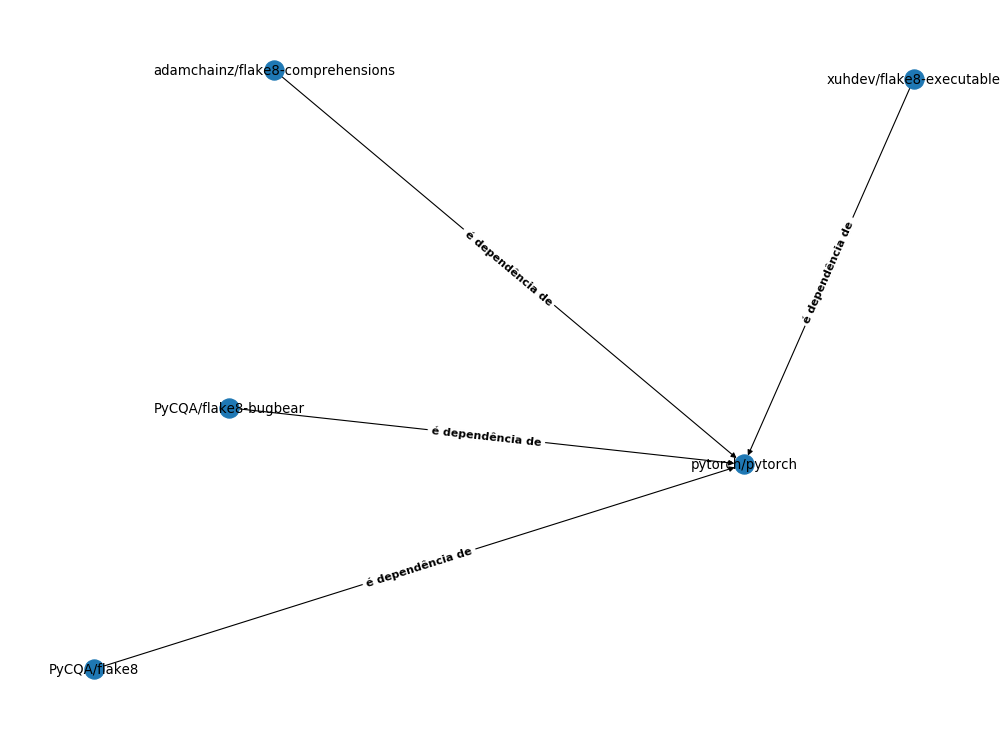

In [6]:
pos = nx.spring_layout(G)
plt.figure(figsize=(2*8, 2*6), dpi=80) 
nx.draw_networkx(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5,
                             font_color='black', font_size=10, font_weight='bold')
plt.axis('off')
plt.show()

Poucos nós para simplificar a visualização

# Rede utilizada no tópico **Visualização: D3.js**

In [7]:
def getDiGraphFromJSON(filename):
    with open(filename) as f:
        json_data = json.load(f)
    G = nx.DiGraph()
    G.add_nodes_from(
        node['id']
        for node in json_data['nodes']
    )

    G.add_edges_from(
        (link['source'], link['target'])
        for link in json_data['links']
    )
    
    return G
    

In [8]:
G = getDiGraphFromJSON(JSON_PATH + 'depth2_pytorch.json')

print('Number of nodes: {}'.format(G.number_of_nodes()))
print('Number of edges: {}'.format(G.number_of_edges()))

Number of nodes: 726
Number of edges: 1371


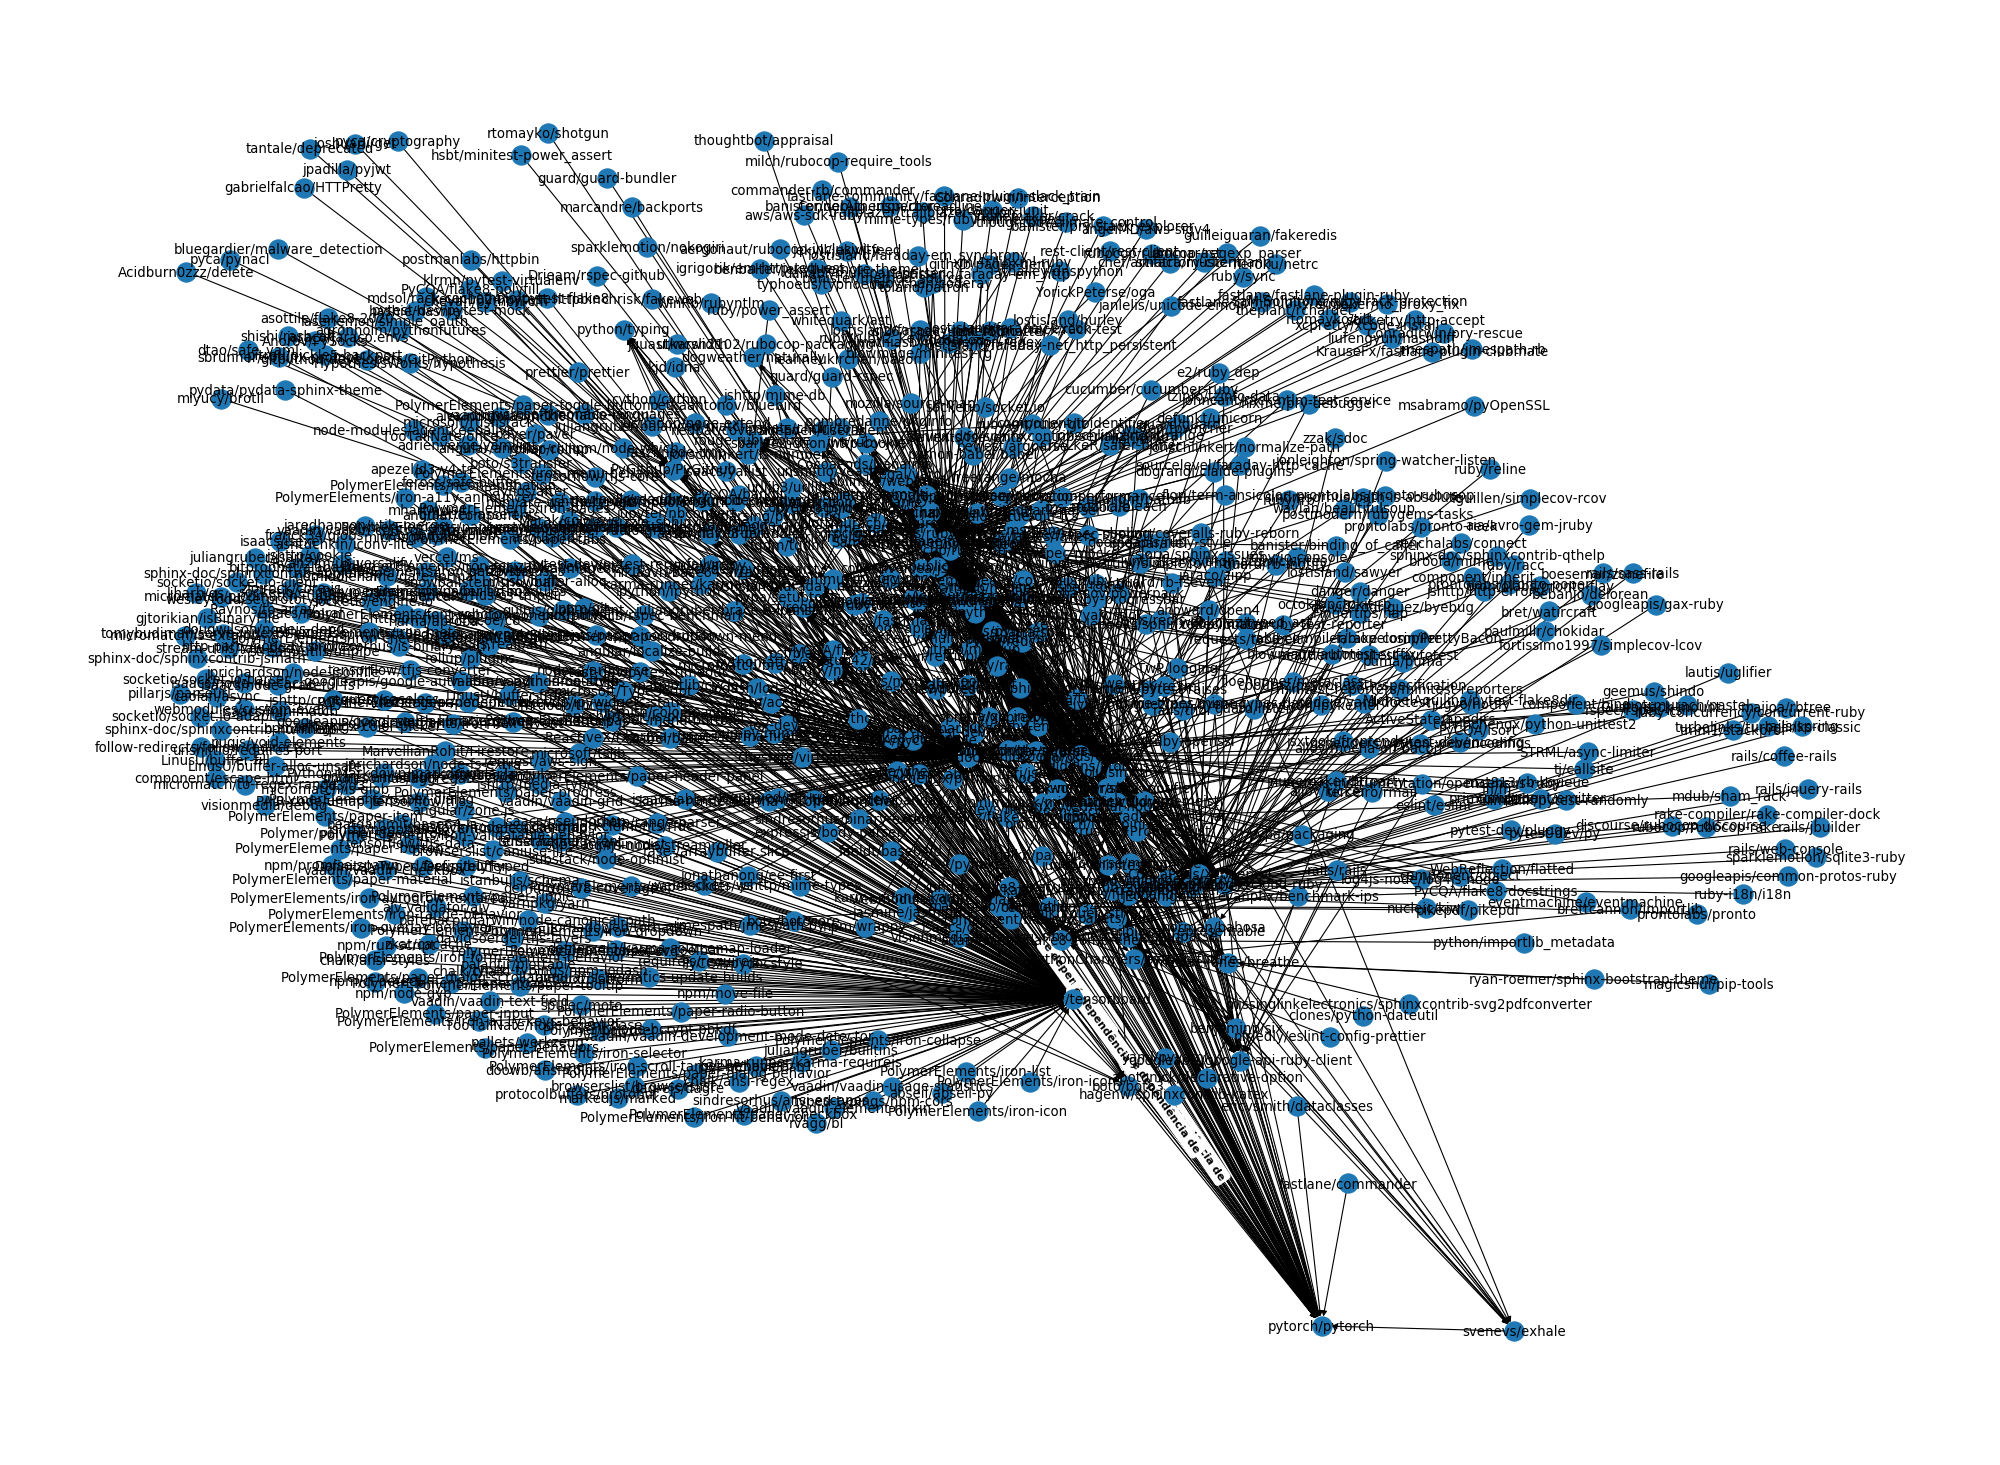

In [9]:
pos = nx.spring_layout(G)
plt.figure(figsize=(4*8, 4*6), dpi=80) 
nx.draw_networkx(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5,
                             font_color='black', font_size=10, font_weight='bold')
plt.axis('off')
plt.show()

## Dúvida 1: Existem repositórios que dependem deles mesmos(loops)?

## Dúvida 2: Existem repositórios que são dependências e dependentes entre si. Ou seja, existe uma aresta $(source, target)$ e uma outra $(target, source)$?

In [10]:
for source, target in G.edges():
    if ((target, source) in G.edges()):
        print(source, target)

sphinx-doc/sphinx pypa/setuptools
python/typing python/typing
numpy/numpy matplotlib/matplotlib
matplotlib/matplotlib numpy/numpy
pypa/setuptools sphinx-doc/sphinx
tensorflow/tensorboard tensorflow/tensorboard
googleapis/google-cloud-ruby googleapis/google-cloud-ruby


Vale visitar o grafo de dependências no site do github para verificar. Essa análise também será feita em uma rede mais completa

# Rede com um dos principais repositórios de Machine Learning e Data Science(depth = 3) e alguns dependentes

Foram retiradas as dependências e depentendes dos sequintes repositórios:
* tensorflow/tensorflow;
* scikit-learn/scikit-learn;
* keras-team/keras;
* pytorch/pytorch;
* pandas-dev/pandas;
* matplotlib/matplotlib.

Foram exploradas as seguintes métricas:
* Self Loops
* Dependências(dependentes) entre si
* Degree Centrality
* In-Degree Centrality
* Out-Degree Centrality
* Page Rank
* K-Core

In [11]:
def get10HighestCentrality(centralities):
    sorted_centralities = sorted(centralities, key = centralities.get, reverse = True)
    sorted_nodes = [n for n in sorted_centralities]

    for i, node in enumerate(sorted_nodes[:10]):
        print("{}) {} - score {}".format(i+1, node, centralities[node]))

In [12]:
from collections import defaultdict
interval = 1000
def getMetrics(filename):
    G = getDiGraphFromJSON(filename)
    print('Number of nodes: {}'.format(G.number_of_nodes()))
    print('Number of edges: {}'.format(G.number_of_edges()))
    
    print('\n\nSelf Loops')
    count = 0
    for node in G.nodes():
        if (node, node) in G.edges():
            if count % interval == 0:
                print(f'\t{node}')
            count += 1
    print(f'Total: {count}')
            
    print('\n\nDependências(dependentes) entre si')
    count = 0
    for source, target in G.edges():
        if source != target:
            if count % interval == 0:
                print(f'\t{source} <--------> {target}')
            count += 1
    print(f'Total: {count}')
        
    
    print('\n\nDegree Centrality:\n')
    get10HighestCentrality(nx.degree_centrality(G))
    
    print('\n\nDegree in Degree Centrality:\n')
    get10HighestCentrality(nx.in_degree_centrality(G))
    
    print('\n\nDegree out Degree Centrality:\n')
    get10HighestCentrality(nx.out_degree_centrality(G))
        
    print('\n\nPage Rank:\n')
    get10HighestCentrality(nx.pagerank(G))
    
    print('\n\n5 Nós com maior grau para cada k core:\n')
    G.remove_edges_from(nx.selfloop_edges(G)) # removendo self loops
    
    # antes,transformando o resultado de core_number em um dicionario do tipo 
    # {1: [repo0, ...], ..., k: [repo1, repo2]}
    k_cores = nx.core_number(G)
    dict_kcore = defaultdict(list)
    for key, value in k_cores.items():
        dict_kcore[value].append(key)
    
    for k, nodes in sorted(dict_kcore.items()):
        nodes_degree = G.degree(nodes)
        sorted_nodes = sorted(nodes_degree, key = lambda x: x[1], reverse = True)
        print(f'k core {k}')
        for node, degree in sorted_nodes[:5]:
            print(f'\trepo: {node}, degree = {degree}')
        print()    

### Sem filtragem das arestas por quantidade de estrelas

In [13]:
file = JSON_PATH + 'ML_0.json'
print(f'Testando o arquivo {file}')
getMetrics(file)

Testando o arquivo ../dataset/json/ML_0.json
Number of nodes: 11126
Number of edges: 69777


Self Loops
	rails/rails
Total: 139


Dependências(dependentes) entre si
	macournoyer/thin <--------> rails/rails
	lemurheavy/coveralls-ruby <--------> guard/rb-inotify
	tensorflow/tensorflow <--------> kad99kev/TFonMac
	mime-types/ruby-mime-types <--------> octokit/octokit.rb
	browserify/resolve <--------> evanw/node-source-map-support
	royriojas/flat-cache <--------> tj/commander.js
	matplotlib/matplotlib <--------> pjx98/Quote-of-the-day-Revised-
	ipython/ipykernel <--------> pandas-dev/pandas
	epoberezkin/fast-deep-equal <--------> janl/node-jsonpointer
	mochajs/mocha <--------> PolymerElements/iron-fit-behavior
	chaijs/chai <--------> PolymerElements/paper-tabs
	trentm/node-dashdash <--------> npm/node-semver
	juliangruber/balanced-match <--------> lydell/js-tokens
	microsoft/TypeScript <--------> PolymerElements/paper-listbox
	iarna/aproba <--------> babel/babylon
	stefanpenner/get-caller-

### Com filtragem das arestas por quantidade de estrelas (no mínimo 100)

In [14]:
file = JSON_PATH + 'ML_100.json'
print(f'Testando o arquivo {file}')
getMetrics(file)

Testando o arquivo ../dataset/json/ML_100.json
Number of nodes: 2470
Number of edges: 22730


Self Loops
	rails/rails
Total: 113


Dependências(dependentes) entre si
	macournoyer/thin <--------> rails/rails
	karma-runner/karma <--------> karma-runner/karma-jasmine
	enquirer/enquirer <--------> tensorflow/tfjs
	Marak/colors.js <--------> karma-runner/karma-jasmine
	vercel/ms <--------> gkz/optionator
	juliangruber/brace-expansion <--------> PolymerElements/paper-styles
	csstree/csstree <--------> blakeembrey/change-case
	prettier/prettier <--------> royriojas/flat-cache
	enkessler/childprocess <--------> rails/rails
	estools/esutils <--------> follow-redirects/follow-redirects
	component/emitter <--------> prettier/prettier
	micromatch/braces <--------> prettier/prettier
	felixge/node-combined-stream <--------> socketio/engine.io
	npm/ini <--------> mwouts/jupytext
	justmoon/node-extend <--------> WebReflection/flatted
	sindresorhus/get-stream <--------> ReactiveX/rxjs
	bahamas10/css-co